In [1]:
!ml cuda/10.2.89.440
from faimed3d.all import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

from glob import glob
import os

In [3]:
qsm_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*qsm.nii*"))
seg_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*segmentation_clean_seeds.nii*"))
t2s_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*t2starmap.nii*"))
mag_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))
assert(len(qsm_files) == len(seg_files) == len(t2s_files) == len(mag_files))
print(f"{len(qsm_files)} samples.")

In [4]:
# define input data
d = pd.DataFrame({
    'qsm'  : qsm_files, 
    'masks': seg_files
})
print(d)

In [5]:
# show some input data
TensorDicom3D.create(d.qsm[0]).show()
TensorDicom3D.create(d.masks[0]).show()

In [7]:
# 
dls = SegmentationDataLoaders3D.from_df(
    df=d,
    path='.',
    item_tfms=ResizeCrop3D((0, 0, 0), (50, 50, 50)), # one or several transforms applied to the items before batching them
    bs=2, # how many samples per batch to load (overridden by batch_size if specified)
    val_bs=1, # batch size for validation (defaults to bs)
    splitter=RandomSplitter(valid_pct=0.2) # random split 20% / 80%
    #item_tfms = ResizeCrop3D((0, 0, 0), (20, 224, 224)), 
    #batch_tfms = [RandomPerspective3D(224, 0.5), 
    #*aug_transforms_3d(p_all=0.15, noise=False)],
)

In [8]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [10]:
learn = unet_learner_3d(
    dls,
    r3d_18,
    n_out=2, 
    loss_func = loss,
    metrics = dice_score,
    model_dir = 'models',
    cbs = [SaveModelCallback(monitor='dice_score')]
)
learn = learn.to_fp16()
learn.load('models')

FileNotFoundError: [Errno 2] No such file or directory: 'models/models.pth'

SuggestedLRs(valley=0.0012022644514217973)

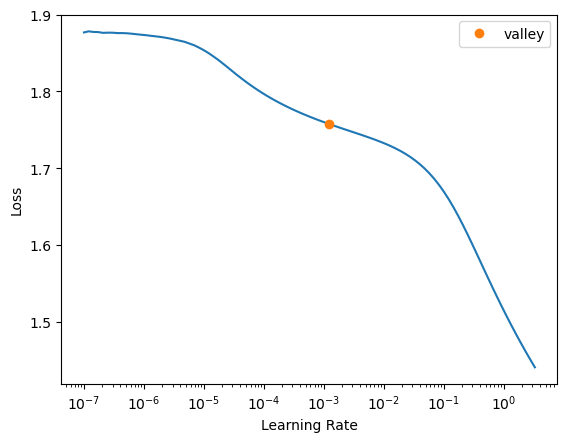

In [9]:
learn.lr_find()

In [10]:
#learn.fit_one_cycle(n_epoch=3, lr_max=0.01, wd=1e-4)
learn.fit_one_cycle(n_epoch=200, lr_max=0.01, wd=1e-4)

epoch,train_loss,valid_loss,dice_score,time
0,1.793794,2.319728,0.000120,00:02
1,1.740652,1.437877,0.000000,00:02
2,1.722202,1.423337,0.000000,00:03
3,1.712436,1.464146,0.000000,00:03
4,1.706095,1.505953,0.000000,00:03
5,1.701401,1.535579,0.000000,00:03
6,1.697572,1.571900,0.000000,00:03
7,1.694202,1.591612,0.000000,00:03
8,1.691051,1.614746,0.000000,00:02
9,1.687965,1.636306,0.000000,00:03


Better model found at epoch 0 with dice_score value: 0.00012030633661197498.


In [11]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch=500, lr_max=1e-3, wd=1e-4)

epoch,train_loss,valid_loss,dice_score,time
0,1.692106,1.717023,0.000176,00:03
1,1.691768,1.664855,0.000000,00:03
2,1.691570,1.663615,0.000000,00:03
3,1.691417,1.670009,0.000000,00:03
4,1.691282,1.675564,0.000000,00:03
5,1.691156,1.678091,0.000000,00:03
6,1.691032,1.678979,0.000000,00:03
7,1.690907,1.679880,0.000000,00:03
8,1.690781,1.682132,0.000265,00:03
9,1.690652,1.685045,0.000286,00:03


Better model found at epoch 0 with dice_score value: 0.00017587745969649404.
Better model found at epoch 8 with dice_score value: 0.00026544020511209965.
Better model found at epoch 9 with dice_score value: 0.0002860181557480246.
Better model found at epoch 20 with dice_score value: 0.0003191180876456201.
Better model found at epoch 22 with dice_score value: 0.0004221837152726948.
Better model found at epoch 23 with dice_score value: 0.0005527440225705504.


In [12]:
dls = SegmentationDataLoaders3D.from_df(
    d, path = '.',
    item_tfms = ResizeCrop3D((0, 0, 0), (50, 50, 50)), 
    batch_tfms = [RandomPerspective3D(50, 0.5), 
    *aug_transforms_3d(p_all=0.5)],
    bs = 1, 
    val_bs = 1,
    splitter = ColSplitter('is_valid')
)

In [2]:
learn = learn.load('model')

NameError: name 'learn' is not defined

In [14]:
inp, pred, target = learn.get_preds(with_input = True)

<class 'faimed3d.basics.TensorDicom3D'>


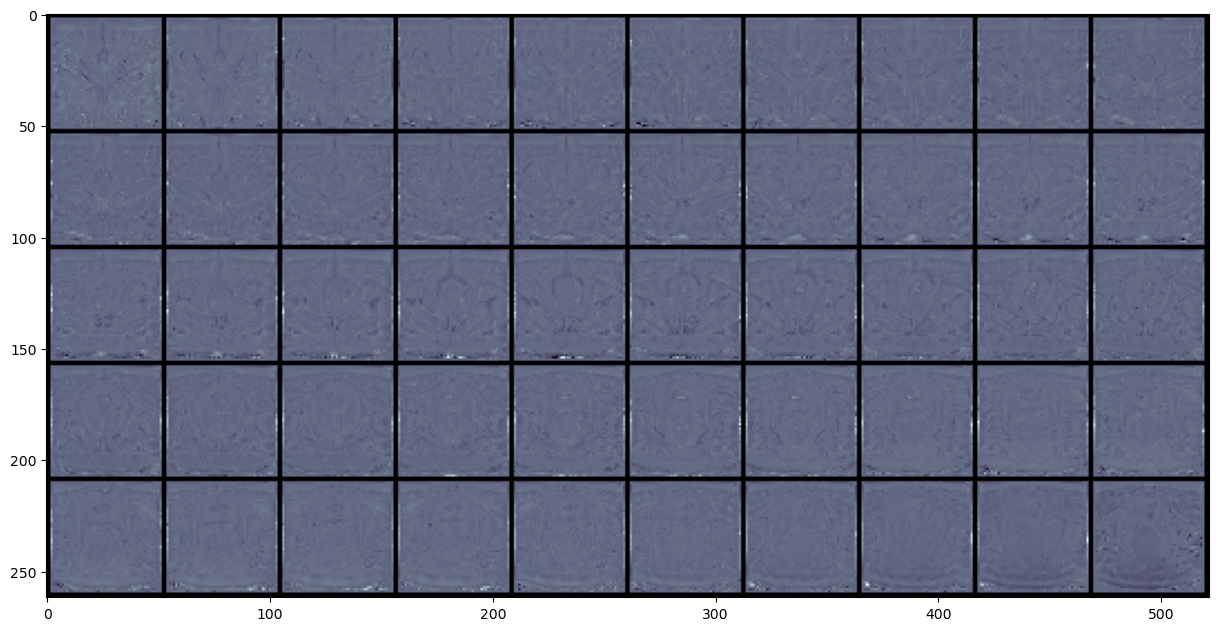

In [38]:
print(type(inp))
show_image_3d(inp[0], axis = 0, nrow = 10)
#inp.show(nrow=10, figsize = (30, 30))
#inp.show()

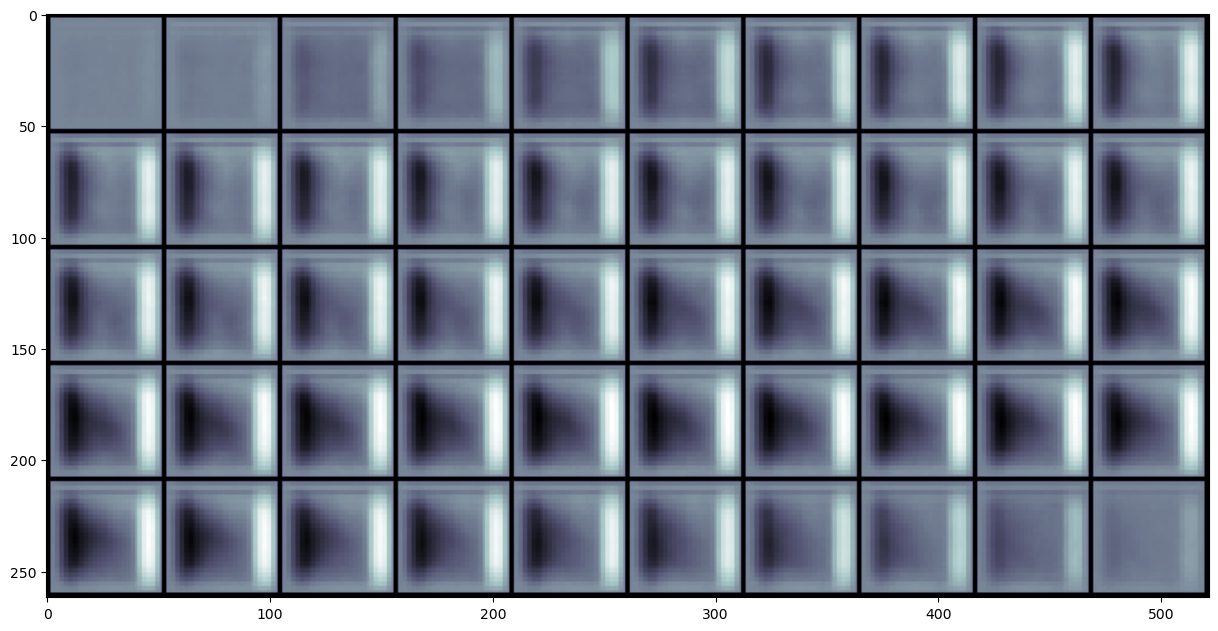

In [37]:
#pred.argmax(1).show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')
show_image_3d(pred[0], axis = 0, nrow = 10)

In [34]:
inp.show(nrow=10, figsize = (30, 30))

TypeError: __init__() got an unexpected keyword argument 'nrow'

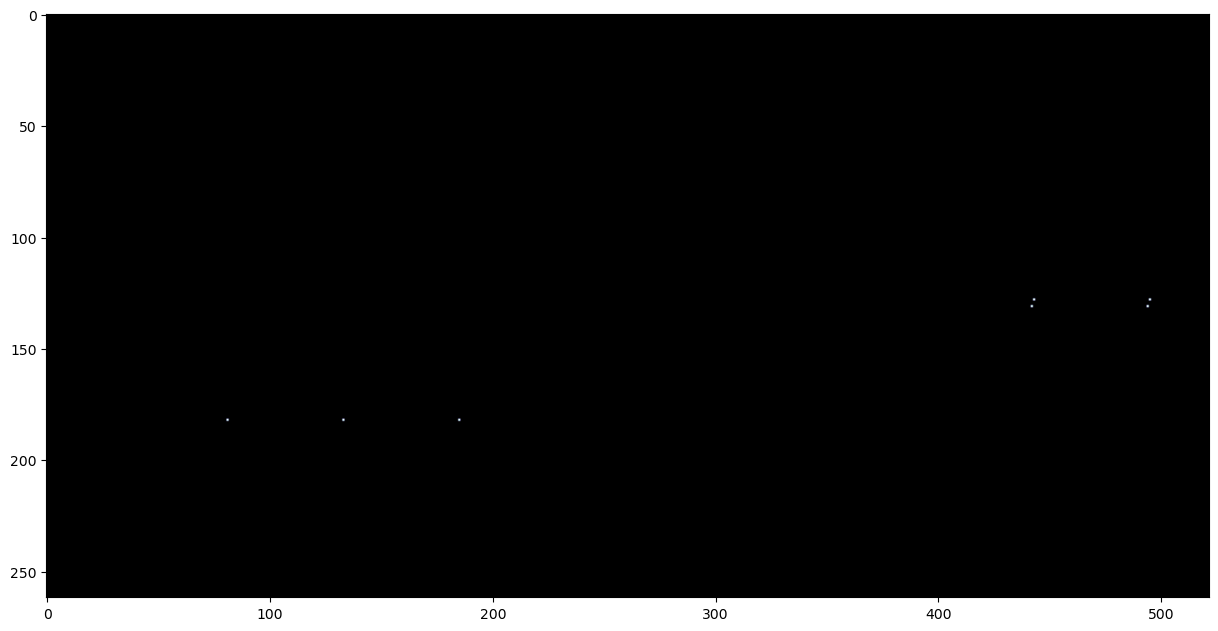

In [36]:
#target.show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')
show_image_3d(target[0], axis = 0, nrow = 10)

In [16]:
dice_score(pred, target)

tensor(0.0004)

In [17]:
TensorMask3D(0.7255)

TensorMask3D(0.7255)